# EDA

In [2]:
"""

    This script collects utility functions to make the flow file smaller and more readable.

"""
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def feature_preprocess(data):
    '''
    this function is to label categorical column and 
    generate shift and pecent change features based on origial features
    '''
    data.set_index('observation_date', inplace = True)
    target = ['Target_category']
    num_features = ['PCE','Consumer_Sentiment','Supply_NewHouse','CPI','ISM PMI','Housing_starts','Unemp_rate','SPX','10y_try','sentiment_score_LM']
    cat_features = ['Sentiment']
    data2 = data[target + num_features+cat_features]
    data2 = data2.ffill() # use last value to fill nan
    
    # label sentiment and target
    sentiment_mapping = {
        'positive': 1,
        'negative': -1,
        'neutral': 0
    }
    target_mapping = {
        'increase': 1,
        'decrease': -1,
        'hold': 0
    }
    data = data.copy()
    data2['Sentiment'] = data2['Sentiment'].map(sentiment_mapping)
    data2['Target_category'] = data2['Target_category'].map(target_mapping)

    # shift data 
    def shift_data(data, n):
        data_shift = data.shift(n)
        colnames = [fea + '_s' + str(n) for fea in data.columns]
        data_shift.columns = colnames
        return data_shift

    # percent change for numerical feature
    def pctchg_data(data):
        data_pctchg = data.pct_change()
        colnames = [fea + '_pctchg' for fea in data.columns]
        data_pctchg.columns = colnames
        return data_pctchg

    df_shift1 = shift_data(data2[num_features+cat_features], 1)
    df_shift2 = shift_data(data2[num_features+cat_features], 2)
    df_shift3 = shift_data(data2[num_features+cat_features], 3)
    df_pctchg = pctchg_data(data2[num_features])
    df_pctchg_shift1 = shift_data(df_pctchg, 1)
    df_pctchg_shift2 = shift_data(df_pctchg, 2)
    df_pctchg_shift3 = shift_data(df_pctchg, 3)

    df_all = pd.concat([data2,
            df_shift1,
            df_shift2,
            df_shift3,
            df_pctchg,
            df_pctchg_shift1,
            df_pctchg_shift2,
            df_pctchg_shift3], axis = 1)
    
    df_all.index = pd.to_datetime(df_all.index)
    
    return df_all

def data_slice(data, date_start):
    '''
    this function is to select data from date_start and to fill in empty data
    '''
    data2 = data[data.index>= date_start]
    data2= data2.bfill().ffill()
    data2 = data2.replace(np.Inf,0).replace(-np.Inf, 0)
    return data2

def feature_selection_lasso(data, target, alpha_):
    '''
    target: the target column name
    alpha_: the parameter of lasso regression, the extent of penalty
    '''
    from sklearn.linear_model import Lasso
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    # 分离特征和目标变量
    X = data.drop(target, axis=1)  # 替换target_column_name为目标变量列名
    y = data[target]  # 目标变量

    # 2. 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. 应用Lasso回归
    lasso = Lasso(alpha=alpha_)  # alpha值可以调整
    lasso.fit(X_scaled, y)

    # 4. 选择特征
    selected_features = X.columns[(lasso.coef_ != 0)]

    print("Selected Features:", selected_features)
    print("length of Selected Features:", len(selected_features))
    return selected_features

In [3]:
def PCA_dataFrame(yield_values):
    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    yield_values_standardized = scaler.fit_transform(yield_values)

    # Remove rows with NaN values
    yield_values_standardized = yield_values_standardized[~np.isnan(yield_values_standardized).any(axis=1)]

    # Perform PCA with a specific number of components (e.g., 2)
    pca = PCA(n_components=5)
    principal_components = pca.fit_transform(yield_values_standardized)

    # Loadings
    loadings = pd.DataFrame(pca.components_, columns=yield_values.columns, index=['PC1', 'PC2','PC3','PC4','PC5'])
    return loadings

In [4]:
df = pd.read_csv("dataset_merged_with_sentiment.csv")
df.head()

,observation_date,month,FEDFUNDS,Target,Target_category,PCE,Consumer_Sentiment,Supply_NewHouse,CPI,ISM PMI,...,year_month,content,word_count,Sentiment,Sentiment_score,sentiment_score_LM,NPositiveWords,NNegativeWords,Poswords,Negwords
0,1954/7/1,Jul,0.80,NaN,NaN,NaN,NaN,NaN,26.86,63.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1954/8/1,Aug,1.22,0.525000,increase,NaN,NaN,NaN,26.85,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1954/9/1,Sep,1.07,-0.122951,decrease,NaN,NaN,NaN,26.81,62.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1954/10/1,Oct,0.85,-0.205607,decrease,NaN,NaN,NaN,26.72,66.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1954/11/1,Nov,0.83,-0.023529,decrease,NaN,NaN,NaN,26.78,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data = feature_preprocess(df)

In [6]:
data

,Target_category,PCE,Consumer_Sentiment,Supply_NewHouse,CPI,ISM PMI,Housing_starts,Unemp_rate,SPX,10y_try,...,PCE_pctchg_s3,Consumer_Sentiment_pctchg_s3,Supply_NewHouse_pctchg_s3,CPI_pctchg_s3,ISM PMI_pctchg_s3,Housing_starts_pctchg_s3,Unemp_rate_pctchg_s3,SPX_pctchg_s3,10y_try_pctchg_s3,sentiment_score_LM_pctchg_s3
observation_date,,,,,,,,,,,,,,,,,,,,,
1954-07-01,NaN,NaN,NaN,NaN,26.860,63.8,NaN,5.8,30.88,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-08-01,1.0,NaN,NaN,NaN,26.850,56.6,NaN,6.0,29.83,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-09-01,-1.0,NaN,NaN,NaN,26.810,62.2,NaN,6.1,32.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-10-01,-1.0,NaN,NaN,NaN,26.720,66.7,NaN,5.7,31.68,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954-11-01,-1.0,NaN,NaN,NaN,26.780,66.0,NaN,5.3,34.24,NaN,...,NaN,NaN,NaN,-0.000372,-0.112853,NaN,0.034483,-0.034003,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,1.0,118.984,97.21225,7.2,303.294,46.9,1496.0,3.7,4179.83,3.646,...,0.003593,0.001198,0.037037,0.003700,0.006329,0.094535,0.058824,-0.026112,0.117345,-1.000000
2023-06-01,1.0,119.189,97.50814,7.5,303.841,46.0,1441.0,3.6,4450.38,3.840,...,0.003359,-0.001191,-0.035714,0.000530,-0.029350,-0.030364,-0.027778,0.035052,-0.115473,NaN
2023-07-01,1.0,119.449,97.87399,7.0,304.348,46.4,1443.0,3.5,4588.96,3.962,...,0.003069,-0.000997,-0.061728,0.003678,0.017279,-0.013918,-0.028571,0.014642,-0.012968,NaN


In [7]:
data2 = data_slice(data, '1994-01-01')

In [8]:
data2.head()

,Target_category,PCE,Consumer_Sentiment,Supply_NewHouse,CPI,ISM PMI,Housing_starts,Unemp_rate,SPX,10y_try,...,PCE_pctchg_s3,Consumer_Sentiment_pctchg_s3,Supply_NewHouse_pctchg_s3,CPI_pctchg_s3,ISM PMI_pctchg_s3,Housing_starts_pctchg_s3,Unemp_rate_pctchg_s3,SPX_pctchg_s3,10y_try_pctchg_s3,sentiment_score_LM_pctchg_s3
observation_date,,,,,,,,,,,,,,,,,,,,,
1994-01-01,1.0,66.902,100.6814,5.9,146.3,63.5,1390.0,6.6,481.61,5.642,...,0.001638,0.002882,0.020408,0.004138,0.119772,0.028777,0.014925,0.019393,0.008361,0.0
1994-02-01,1.0,67.047,100.8347,5.0,146.7,62.2,1269.0,6.6,467.14,6.129,...,0.002581,0.003455,-0.040000,0.002747,0.025467,0.054390,-0.029412,-0.012911,0.072231,0.0
1994-03-01,1.0,67.275,100.8237,4.8,147.1,62.8,1342.0,6.5,445.77,6.738,...,0.000449,0.004996,-0.062500,0.002055,0.033113,0.076640,-0.015152,0.010091,-0.004296,0.0
1994-04-01,1.0,67.376,100.7935,5.2,147.2,62.7,1392.0,6.4,450.91,7.042,...,0.000793,0.004280,0.311111,0.000000,0.017628,-0.048597,0.015385,0.032501,-0.026234,0.0
1994-05-01,1.0,67.526,100.7298,5.3,147.5,61.6,1396.0,6.1,456.50,7.147,...,0.002167,0.001523,-0.152542,0.002734,-0.020472,-0.087050,0.000000,-0.030045,0.086317,0.0


In [9]:
df = data2[['Target_category','PCE_pctchg_s1', 'Consumer_Sentiment_pctchg_s1',
     'Supply_NewHouse_pctchg_s1','CPI_pctchg_s1','ISM PMI_pctchg_s1','Housing_starts_pctchg_s1','Unemp_rate_pctchg_s1',
     'SPX_pctchg_s1','10y_try_pctchg_s1','sentiment_score_LM_s1','Sentiment_s1','sentiment_score_LM_pctchg_s1']]

In [10]:
df.head()

,Target_category,PCE_pctchg_s1,Consumer_Sentiment_pctchg_s1,Supply_NewHouse_pctchg_s1,CPI_pctchg_s1,ISM PMI_pctchg_s1,Housing_starts_pctchg_s1,Unemp_rate_pctchg_s1,SPX_pctchg_s1,10y_try_pctchg_s1,sentiment_score_LM_s1,Sentiment_s1,sentiment_score_LM_pctchg_s1
observation_date,,,,,,,,,,,,,
1994-01-01,1.0,0.000449,0.004996,-0.062500,0.002055,0.033113,0.076640,-0.015152,0.010091,-0.004296,0.0,0.0,0.0
1994-02-01,1.0,0.000793,0.004280,0.311111,0.000000,0.017628,-0.048597,0.015385,0.032501,-0.026234,0.0,0.0,0.0
1994-03-01,1.0,0.002167,0.001523,-0.152542,0.002734,-0.020472,-0.087050,0.000000,-0.030045,0.086317,0.0,0.0,0.0
1994-04-01,1.0,0.003401,-0.000109,-0.040000,0.002727,0.009646,0.057526,-0.015152,-0.045746,0.099364,0.0,1.0,0.0
1994-05-01,1.0,0.001501,-0.000300,0.083333,0.000680,-0.001592,0.037258,-0.015385,0.011531,0.045117,0.0,1.0,0.0


In [11]:
df.reset_index(inplace=True)
# Convert the 'DateColumn' to datetime format
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Format the 'DateColumn' as '07/01/1954'
df['observation_date'] = df['observation_date'].dt.strftime('%m/%d/%Y')

df['date'] = pd.to_datetime(df['observation_date'], format='%m/%d/%Y')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   observation_date              357 non-null    object        
 1   Target_category               357 non-null    float64       
 2   PCE_pctchg_s1                 357 non-null    float64       
 3   Consumer_Sentiment_pctchg_s1  357 non-null    float64       
 4   Supply_NewHouse_pctchg_s1     357 non-null    float64       
 5   CPI_pctchg_s1                 357 non-null    float64       
 6   ISM PMI_pctchg_s1             357 non-null    float64       
 7   Housing_starts_pctchg_s1      357 non-null    float64       
 8   Unemp_rate_pctchg_s1          357 non-null    float64       
 9   SPX_pctchg_s1                 357 non-null    float64       
 10  10y_try_pctchg_s1             357 non-null    float64       
 11  sentiment_score_LM_s1         35

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## one month prior percent changes

In [12]:
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df.head()

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,observation_date,Target_category,PCE_pctchg_s1,Consumer_Sentiment_pctchg_s1,Supply_NewHouse_pctchg_s1,CPI_pctchg_s1,ISM PMI_pctchg_s1,Housing_starts_pctchg_s1,Unemp_rate_pctchg_s1,SPX_pctchg_s1,10y_try_pctchg_s1,sentiment_score_LM_s1,Sentiment_s1,sentiment_score_LM_pctchg_s1,date,month,quarter,year
0,01/01/1994,1.0,0.000449,0.004996,-0.062500,0.002055,0.033113,0.076640,-0.015152,0.010091,-0.004296,0.0,0.0,0.0,1994-01-01,1,1,1994
1,02/01/1994,1.0,0.000793,0.004280,0.311111,0.000000,0.017628,-0.048597,0.015385,0.032501,-0.026234,0.0,0.0,0.0,1994-02-01,2,1,1994
2,03/01/1994,1.0,0.002167,0.001523,-0.152542,0.002734,-0.020472,-0.087050,0.000000,-0.030045,0.086317,0.0,0.0,0.0,1994-03-01,3,1,1994
3,04/01/1994,1.0,0.003401,-0.000109,-0.040000,0.002727,0.009646,0.057526,-0.015152,-0.045746,0.099364,0.0,1.0,0.0,1994-04-01,4,2,1994
4,05/01/1994,1.0,0.001501,-0.000300,0.083333,0.000680,-0.001592,0.037258,-0.015385,0.011531,0.045117,0.0,1.0,0.0,1994-05-01,5,2,1994


## Histogram

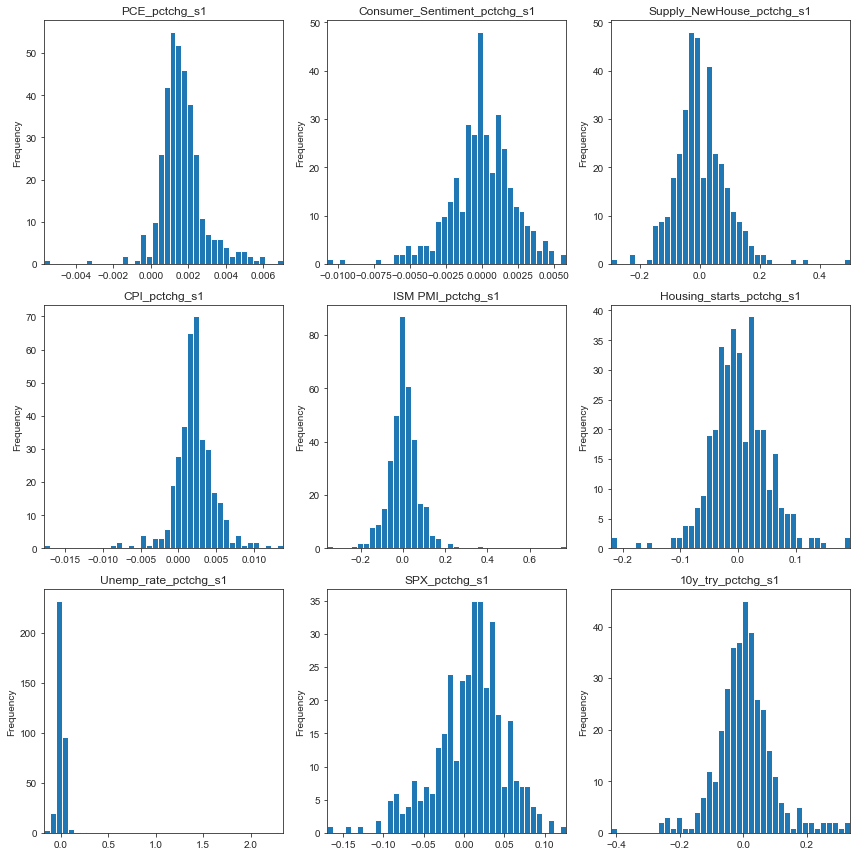

In [45]:
import matplotlib.pyplot as plt
df_hist = df[['PCE_pctchg_s1',
 'Consumer_Sentiment_pctchg_s1',
 'Supply_NewHouse_pctchg_s1',
 'CPI_pctchg_s1',
 'ISM PMI_pctchg_s1',
 'Housing_starts_pctchg_s1',
 'Unemp_rate_pctchg_s1',
 'SPX_pctchg_s1',
 '10y_try_pctchg_s1']]
#df = df.reset_index(drop=True)
# Plot histograms as subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(df_hist.columns):
    df_hist[column].plot(kind='hist', bins=40, ax=axes[i], title=column)
    #axes[i].set_xlim(-1, 1)
    axes[i].set_xlim(df_hist[column].min(), df_hist[column].max())  # Set x-axis limits based on data range

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('example_plot.png', dpi=300)

# Show the plot
plt.show()

## Heatmap

In [17]:
df_heat = df[['Target_category','PCE_pctchg_s1',
 'Consumer_Sentiment_pctchg_s1',
 'Supply_NewHouse_pctchg_s1',
 'CPI_pctchg_s1',
 'ISM PMI_pctchg_s1',
 'Housing_starts_pctchg_s1',
 'Unemp_rate_pctchg_s1',
 'SPX_pctchg_s1',
 '10y_try_pctchg_s1']]

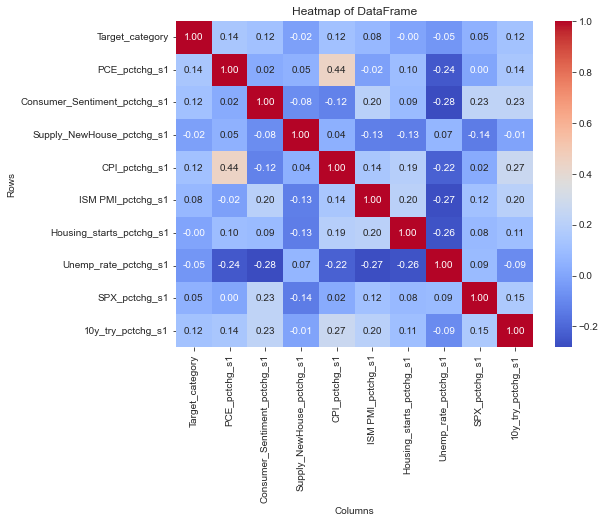

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df_heat.corr()
# Draw a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')  # 'g' for integer format, adjust cmap as needed

# Set labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Heatmap of DataFrame')

plt.savefig('example_plot.png', dpi=300)
# Show the plot
plt.show()

# Boxplot

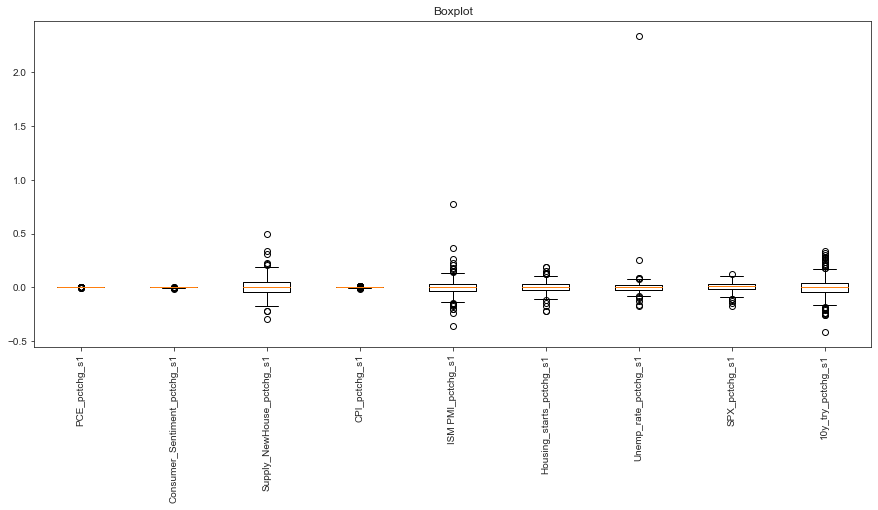

In [47]:
import matplotlib.pyplot as plt

df_box = df[['PCE_pctchg_s1',
 'Consumer_Sentiment_pctchg_s1',
 'Supply_NewHouse_pctchg_s1',
 'CPI_pctchg_s1',
 'ISM PMI_pctchg_s1',
 'Housing_starts_pctchg_s1',
 'Unemp_rate_pctchg_s1',
 'SPX_pctchg_s1',
 '10y_try_pctchg_s1']]

fig, ax = plt.subplots(figsize=(15, 6))
bp = ax.boxplot(df_box.dropna())
ax.set_xticklabels(df_box.columns, rotation=90)
ax.set_title('Boxplot')
plt.savefig('example_plot.png', dpi=300)
plt.show()


## Pairplot

In [27]:
df['month_str'] = df['month'].astype(str)
df['quarter_str'] = df['quarter'].astype(str)

C:\Users\Administrator\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [15]:
names = ['PCE_pctchg_s1',
 'Consumer_Sentiment_pctchg_s1',
 'Supply_NewHouse_pctchg_s1',
 'CPI_pctchg_s1',
 'ISM PMI_pctchg_s1',
 'Housing_starts_pctchg_s1',
 'Unemp_rate_pctchg_s1',
 'SPX_pctchg_s1',
 '10y_try_pctchg_s1']

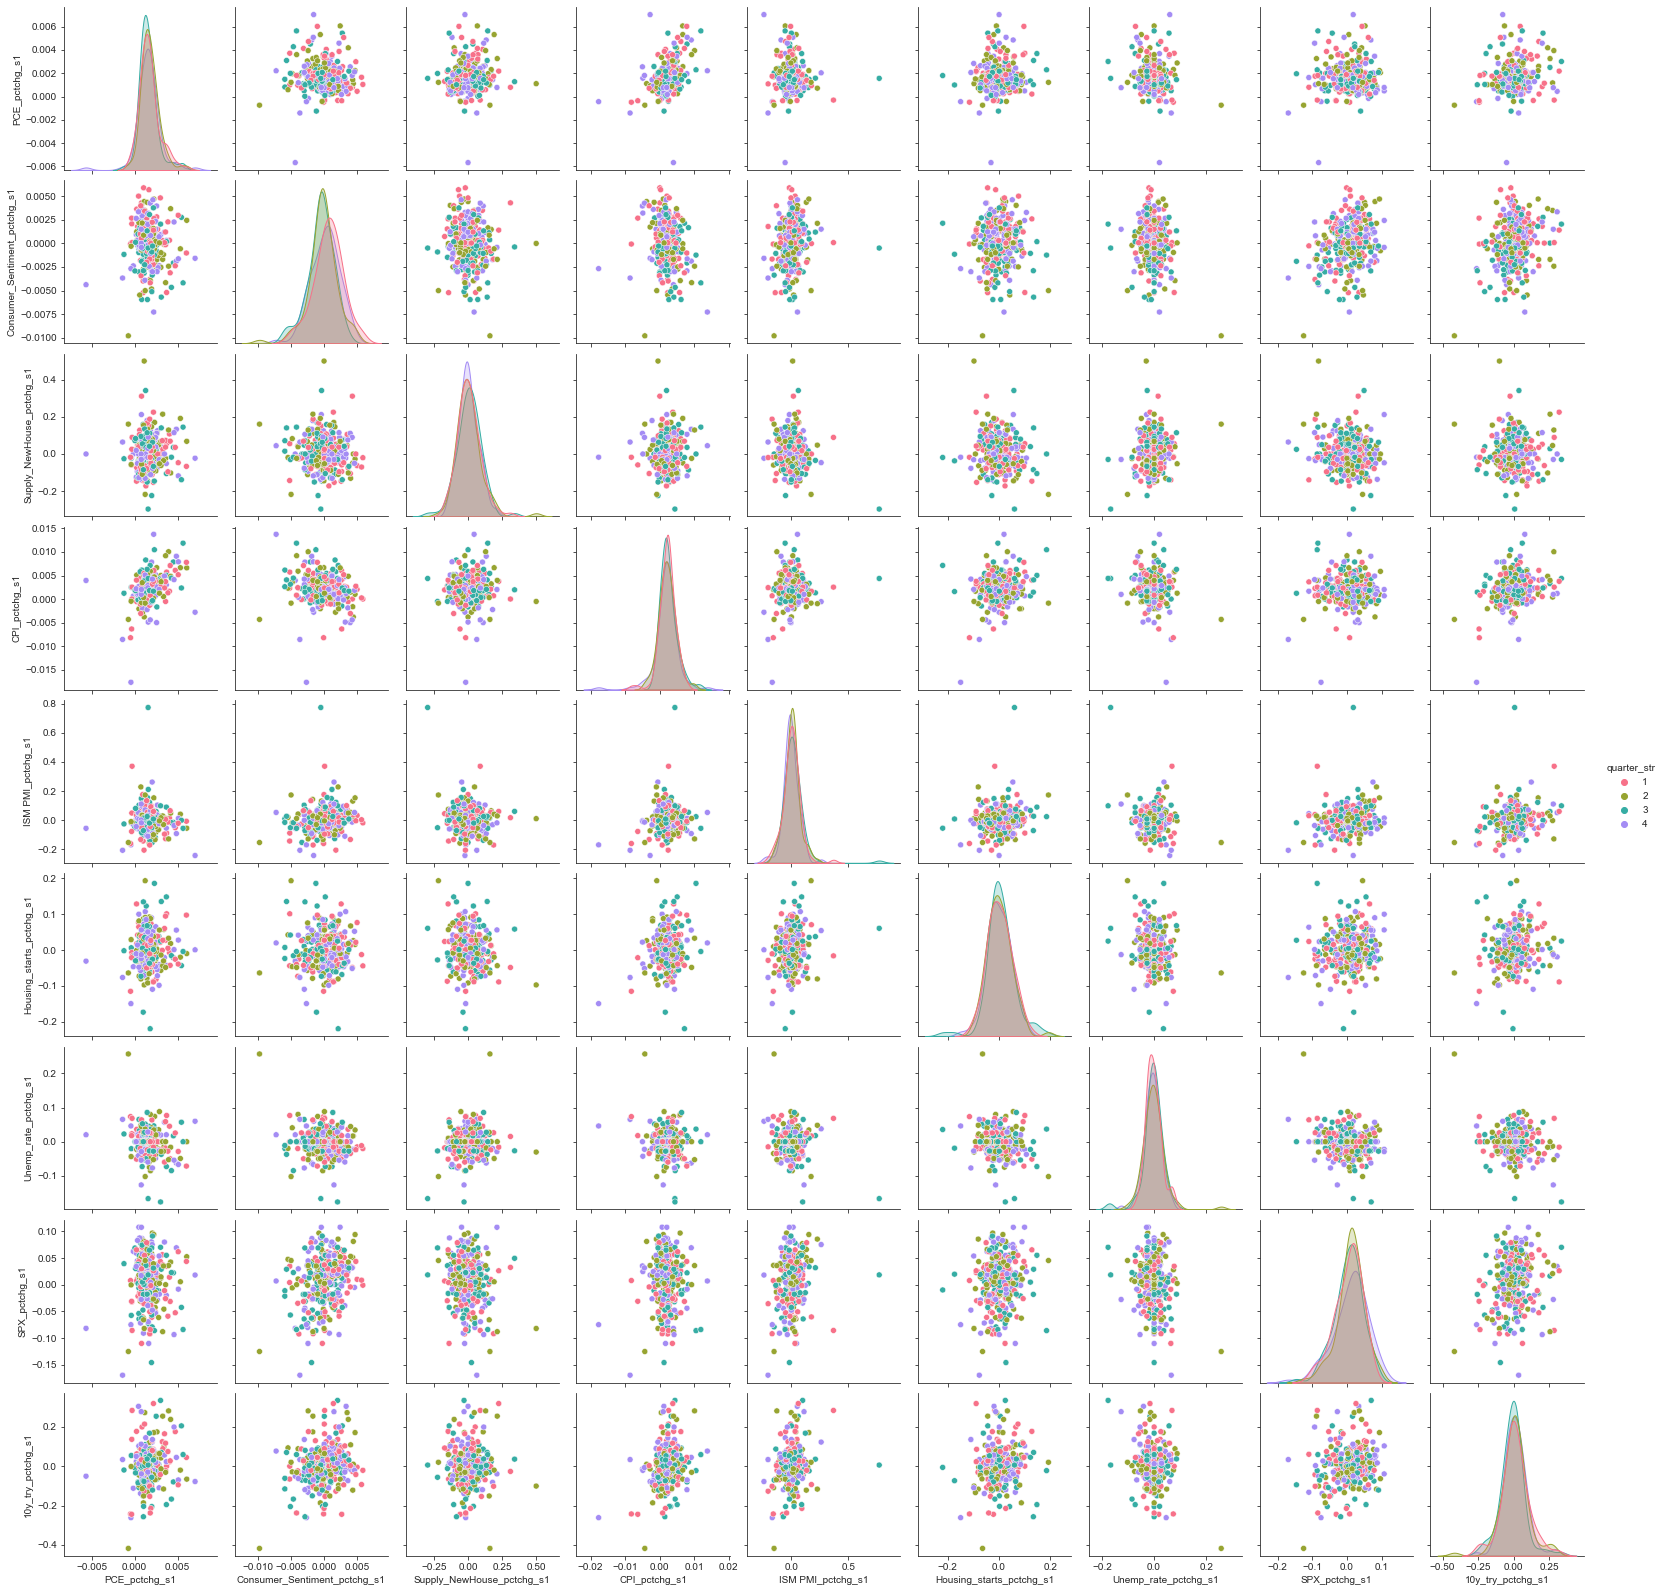

In [48]:
tmp = df[['quarter_str']+names]
sns.set_style('ticks')
sns.pairplot(tmp.dropna().drop(tmp['Unemp_rate_pctchg_s1'].idxmax()),hue = 'quarter_str',diag_kind='kde',kind='scatter',palette='husl')
plt.savefig('example_plot.png', dpi=300)
plt.show()

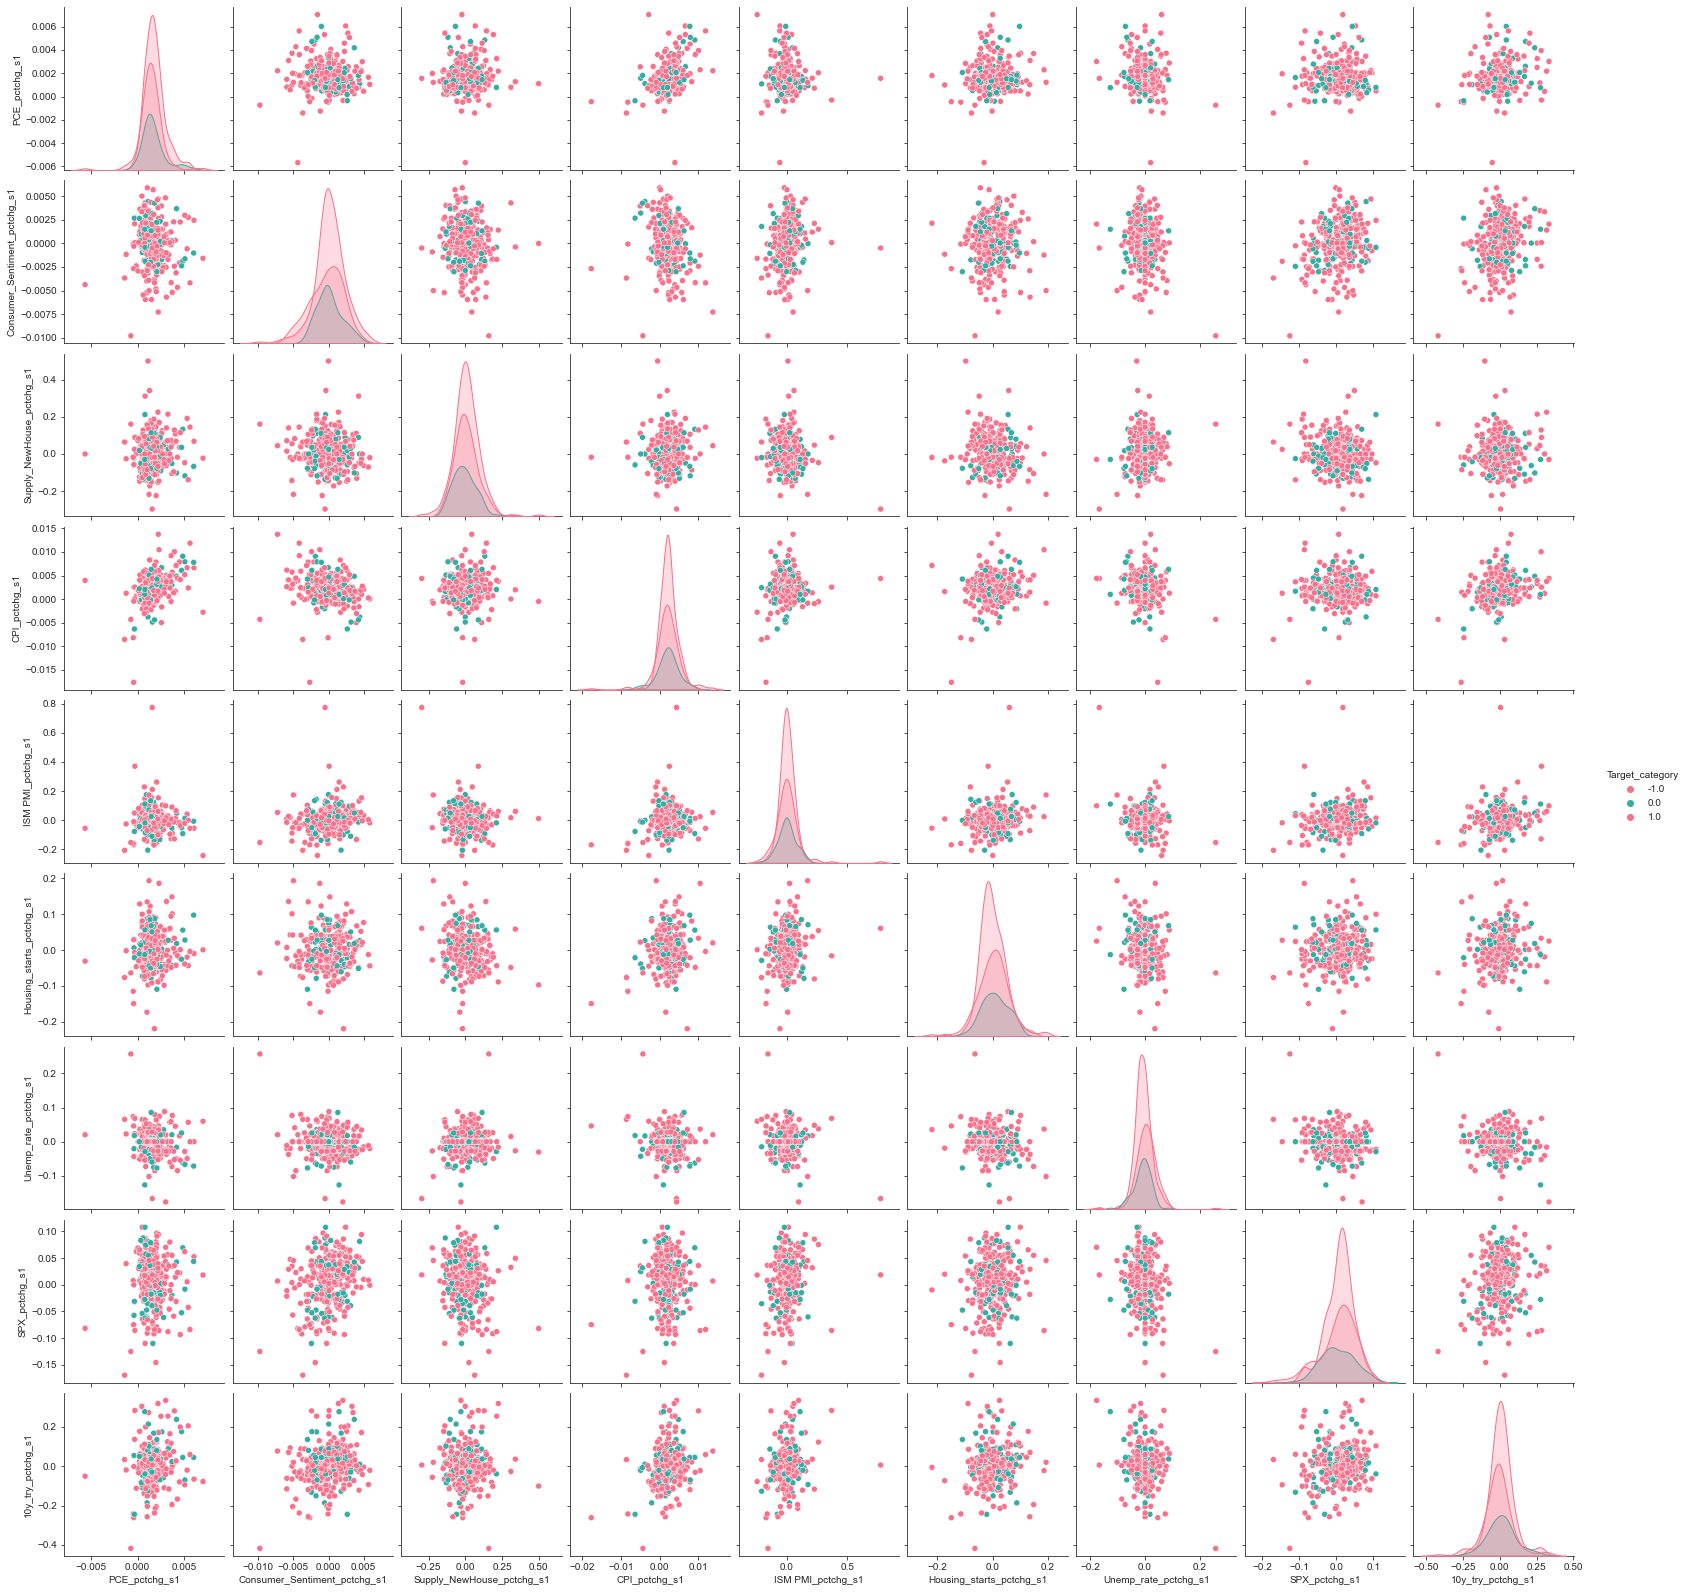

In [49]:
tmp = df[['Target_category']+names]
sns.set_style('ticks')
sns.pairplot(tmp.dropna().drop(tmp['Unemp_rate_pctchg_s1'].idxmax()),hue = 'Target_category',diag_kind='kde',kind='scatter',palette='husl')
plt.savefig('example_plot.png', dpi=300)
plt.show()

In [ ]:
# comment
# the values of independent variables are lowest when target_category is hold, and highest when target_category is increase

## Sentiment features plot

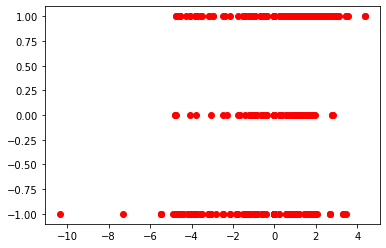

In [16]:
x1 = np.array(df['sentiment_score_LM_s1'])
y = np.array(df['Target_category'])
x2 = np.array(df['Sentiment_s1'])
x3 = np.array(df['sentiment_score_LM_pctchg_s1'])
plt.scatter(x1, y, color='red', label='Set 1')

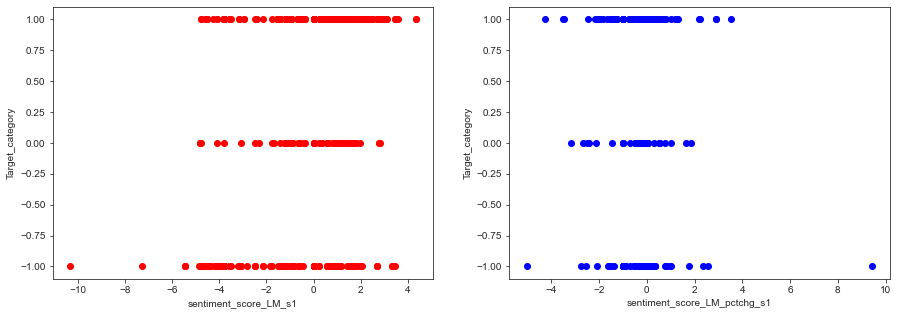

In [50]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot for Set 1
axs[0].scatter(x1, y, color='red')
axs[0].set_xlabel('sentiment_score_LM_s1')
axs[0].set_ylabel('Target_category')

# Scatter plot for Set 3
axs[1].scatter(x3, y, color='blue')
axs[1].set_xlabel('sentiment_score_LM_pctchg_s1')
axs[1].set_ylabel('Target_category')

plt.savefig('example_plot.png', dpi=300)

## PCA viewing loadings

In [17]:
loading = PCA_dataFrame(df[names+['sentiment_score_LM_s1', 'sentiment_score_LM_pctchg_s1']])

In [18]:
loading # loadings represent the correlation between the original variables and the principal components.

,PCE_pctchg_s1,Consumer_Sentiment_pctchg_s1,Supply_NewHouse_pctchg_s1,CPI_pctchg_s1,ISM PMI_pctchg_s1,Housing_starts_pctchg_s1,Unemp_rate_pctchg_s1,SPX_pctchg_s1,10y_try_pctchg_s1,sentiment_score_LM_s1,sentiment_score_LM_pctchg_s1
PC1,-0.345745,-0.293174,0.111043,-0.391787,-0.353365,-0.350520,0.418767,-0.166518,-0.360046,-0.219297,-0.011551
PC2,0.467722,-0.426253,0.361907,0.438310,-0.299380,-0.066914,-0.049242,-0.379943,-0.061213,0.109542,0.140780
PC3,0.077856,-0.017527,0.221175,0.111498,-0.075479,-0.161206,0.485896,0.348537,0.292149,0.404873,-0.541988
PC4,-0.130319,-0.474839,-0.286923,0.190618,0.318572,0.386991,0.069487,-0.217819,-0.185172,-0.147518,-0.528498
PC5,0.117197,-0.283410,-0.373741,0.287440,-0.132119,-0.018053,0.307097,0.461943,0.238241,-0.439717,0.328707


Top features for PC1: Index(['sentiment_score_LM_s1', 'Sentiment_s1', 'sentiment_score_LM_pctchg_s1',
       'Unemp_rate_pctchg_s1', '10y_try_pctchg_s1', 'Housing_starts_pctchg_s1',
       'Supply_NewHouse_pctchg_s1', 'SPX_pctchg_s1', 'ISM PMI_pctchg_s1',
       'CPI_pctchg_s1', 'Consumer_Sentiment_pctchg_s1', 'PCE_pctchg_s1'],
      dtype='object')
[8.05541328e-01 1.45245834e-01 4.30086045e-02 2.54986408e-03
 1.26993193e-03 1.05562666e-03 7.45828922e-04 3.33548770e-04
 2.47644887e-04 1.12034255e-06 5.12143007e-07 1.55959268e-07]


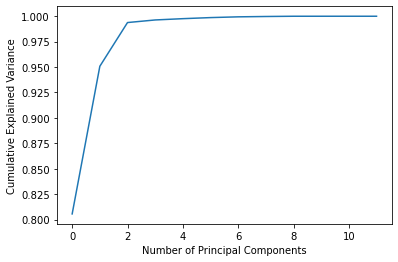

In [19]:
from sklearn.decomposition import PCA

# Assuming X is your feature matrix
X = df[names+['sentiment_score_LM_s1', 'sentiment_score_LM_pctchg_s1','Sentiment_s1']]
pca = PCA()
pca.fit(X)

# Principal components
principal_components = pca.components_

# Loadings (weights) of original features on principal components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Absolute loadings for the first principal component
abs_loadings_pc1 = np.abs(loadings[:, 0])

# Sort features based on their absolute loadings
sorted_indices = np.argsort(abs_loadings_pc1)[::-1]

# Print or visualize the top features for the first principal component
top_features_pc1 = X.columns[sorted_indices]
print("Top features for PC1:", top_features_pc1)

print(pca.explained_variance_ratio_)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.savefig('example_plot.png', dpi=300)
plt.show()


In [13]:
df.columns

Index(['observation_date', 'Target_category', 'PCE_pctchg_s1',
       'Consumer_Sentiment_pctchg_s1', 'Supply_NewHouse_pctchg_s1',
       'CPI_pctchg_s1', 'ISM PMI_pctchg_s1', 'Housing_starts_pctchg_s1',
       'Unemp_rate_pctchg_s1', 'SPX_pctchg_s1', '10y_try_pctchg_s1',
       'sentiment_score_LM_s1', 'Sentiment_s1', 'sentiment_score_LM_pctchg_s1',
       'date', 'month', 'quarter', 'year'],
      dtype='object')

# Check data

In [73]:
X = df[['PCE_pctchg_s1', 'Consumer_Sentiment_pctchg_s1', 'CPI_pctchg_s1', 'ISM PMI_pctchg_s1', 'Unemp_rate_pctchg_s1', 
        '10y_try_pctchg_s1', 'sentiment_score_LM_s1', 'Sentiment_s1']]

In [94]:
# checks for NaN values in a DataFrame and replaces them with the average value of their respective columns:
def replace_nan_with_column_mean(X):
    if(X.isna().any().any()):
        print("There is nan")
        # Replace NaN values with the average value of their respective columns
        X_no_nan = X.apply(lambda col: col.fillna(col.mean()), axis=0)

        return X_no_nan
    else:
        print("There is no nan")
        return X

In [95]:
X_no_nan = replace_nan_with_column_mean(X)

There is no nan


In [92]:
# find extreme values and replace them with respective boundries
def replace_outliers_with_boundaries(X, multiplier=3):
    X_check = X.drop(['sentiment_score_LM_s1', 'Sentiment_s1'], axis=1)
    Q1 = X_check.quantile(0.25)
    Q3 = X_check.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers based on IQR with the specified multiplier
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers_iqr = (X_check < lower_bound) | (X_check > upper_bound)
    
    # Filter DataFrame to include only outlier values
    outlier_values = X_check[outliers_iqr].stack()
    print("outlier values before replacement:")
    print(outlier_values)

    # Replace outliers with their respective boundaries
    X_no_outliers = X_check.clip(lower=lower_bound, upper=upper_bound, axis=1)

    return X_no_outliers

# Example usage with a multiplier of 3
X_no_outliers = replace_outliers_with_boundaries(X, multiplier=3)

outlier values before replacement:
93   PCE_pctchg_s1                  -0.005682
94   PCE_pctchg_s1                   0.007042
95   ISM PMI_pctchg_s1               0.262211
141  CPI_pctchg_s1                   0.013768
178  CPI_pctchg_s1                  -0.008598
179  CPI_pctchg_s1                  -0.017705
180  CPI_pctchg_s1                  -0.008234
181  ISM PMI_pctchg_s1               0.370690
315  Consumer_Sentiment_pctchg_s1   -0.009794
     Unemp_rate_pctchg_s1            0.257143
     10y_try_pctchg_s1              -0.417391
316  PCE_pctchg_s1                  -0.003337
     Consumer_Sentiment_pctchg_s1   -0.010759
     CPI_pctchg_s1                  -0.007872
     ISM PMI_pctchg_s1              -0.357820
     Unemp_rate_pctchg_s1            2.340909
318  ISM PMI_pctchg_s1               0.773585
     Unemp_rate_pctchg_s1           -0.166667
320  Unemp_rate_pctchg_s1           -0.176471
     10y_try_pctchg_s1               0.334594
326  10y_try_pctchg_s1               0.318650